# Multiclass classification with Keras Functional API

In this notebook we will build a multiclass classification model utilizing the [Keras Functional API](https://www.tensorflow.org/guide/keras/functional) to build a ConvNet for the fashion mnist dataset.

The functional API can handle models with non-linear topology, shared layers, as well as layers with multiple input/output. This makes the functional API more flexible compared to the sequential model.

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

from simple_keras import KerasFunctional

2023-05-21 19:52:37.464719: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-05-21 19:52:37.516974: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-05-21 19:52:37.517637: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-21 19:52:38.478037: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/hojve/repos/github/deep-learning/deep-learning-fundamentals/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as 

## Load data

We start by downloading the `Fashion MNIST` dataset created by Zalando. This dataset contains images of different garments which are assigned to 10 different classes.

In [2]:
# Split
split = ['train[:15%]', 'test[:10%]', 'test[10%:20%]']

# Load fashion_mnist dataset
(ds_train, ds_eval, ds_test), ds_info = tfds.load(
    name='fashion_mnist',
    split=split,
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
)

## Inspect dataset

Again, we inspect our data.

In [3]:
len(ds_train)

9000

In [4]:
# Print info
print(len(ds_train))
print(len(ds_eval))
print(len(ds_test))
print(ds_train.element_spec)

# Calculate number of classes in label
num_classes = ds_info.features['label'].num_classes
print(num_classes)

9000
1000
1000
(TensorSpec(shape=(28, 28, 1), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))
10


In [5]:
img_input_shape = (28, 28, 1)
img_n_classes = 10

We visualize some of the images in our training dataset.

2023-05-21 19:52:40.447738: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int64 and shape [1]
	 [[{{node Placeholder/_4}}]]
2023-05-21 19:52:40.448464: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype string and shape [1]
	 [[{{node Placeholder/_2}}]]
2023-05-21 19:52:40.497006: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype string and shape [1]
	 [[{{no

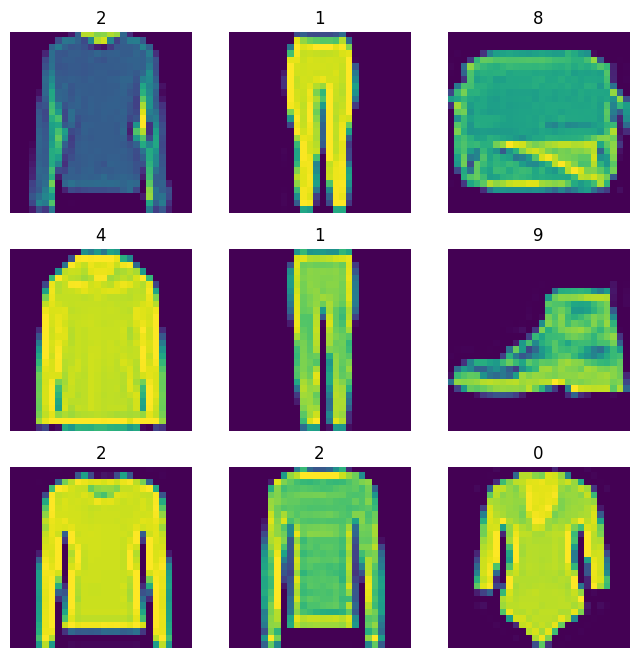

In [6]:
images_iter = iter(x_train for x_train, _ in ds_train.take(9).cache().repeat())
labels_iter = iter(y_train for _, y_train in ds_train.take(9).cache().repeat())
plt.figure(figsize=(8, 8))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(next(images_iter).numpy().astype("uint8"))
    plt.title(next(labels_iter).numpy().astype("uint8"))
    plt.axis("off")

## Preprocess data

We start by preprocessing the pixel values to speed up training. We do a normalization of `255.0` for each pixel.

In [7]:
def normalize(image, label):
    """Normalize image pixels."""
    return tf.cast(image, tf.float32) / 255.0, label

In [8]:
# Normalize train and test data
ds_train = ds_train.map(normalize, num_parallel_calls=tf.data.AUTOTUNE)
ds_eval = ds_eval.map(normalize, num_parallel_calls=tf.data.AUTOTUNE)
ds_test = ds_test.map(normalize, num_parallel_calls=tf.data.AUTOTUNE)

In [9]:
# Print element spec after preprocessing
print(ds_train.element_spec)
print(ds_eval.element_spec)
print(ds_test.element_spec)

(TensorSpec(shape=(28, 28, 1), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))
(TensorSpec(shape=(28, 28, 1), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))
(TensorSpec(shape=(28, 28, 1), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))


### Set up data for training and evaluation

The `Dataset` API has some nice functionalities for speeding up the traning time.

By caching the datasets we we will save some operations (like file opening and data reading) from being executed during each epoch, [reference](https://www.tensorflow.org/guide/data_performance#caching).

First, we take the training data and apply the following steps:
* cache it before shuffling for better performance
* for true randomness, set shuffle buffer to full dataset size
* batch elements of the dataset after shuffling to get unique batches at each epoch
* prefetch to increase performace

In [10]:
# Cache train data
ds_train = ds_train.cache()

# Shuffle data for true randomness and to reduce memory usage
ds_train = ds_train.shuffle(ds_info.splits['train'].num_examples)

# Set batch size
ds_train = ds_train.batch(64)

# Prefetch
ds_train = ds_train.prefetch(tf.data.AUTOTUNE)

Second, we take our evaluation and test data. We do similar steps but skip a few:
* we don't need to shuffle the data
* caching is done after batching because batches can be the same between epochs

In [11]:
# Set batch size
ds_eval = ds_eval.batch(64)
ds_test = ds_test.batch(64)

# Cache test data
ds_eval = ds_eval.cache()
ds_test = ds_test.cache()

# Prefetch
ds_eval = ds_eval.prefetch(tf.data.AUTOTUNE)
ds_test = ds_test.prefetch(tf.data.AUTOTUNE)

## Train model

Next we instantiate the model and let it train for a number of epochs.

In [12]:
# Instantiate classifier
clf = KerasFunctional(input_shape=img_input_shape, n_classes=img_n_classes)

In [13]:
# Train model
clf.call(ds_train=ds_train, ds_eval=ds_eval, epochs=100)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 8)         136       
                                                                 
 re_lu (ReLU)                (None, 28, 28, 8)         0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 4, 4, 8)          0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 4, 4, 16)          528       
                                                                 
 re_lu_1 (ReLU)              (None, 4, 4, 16)          0         
                                                             

2023-05-21 19:52:41.863517: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int64 and shape [1]
	 [[{{node Placeholder/_4}}]]
2023-05-21 19:52:41.864264: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [1]
	 [[{{node Placeholder/_3}}]]
/home/hojve/repos/github/deep-learning/deep-learning-fundamentals/.venv/lib/python3.10/site-packages/keras/backend.py:5612: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
 

136/141 [===========================>..] - ETA: 0s - loss: 2.1939 - accuracy: 0.2533

2023-05-21 19:52:43.938928: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int64 and shape [1]
	 [[{{node Placeholder/_4}}]]
2023-05-21 19:52:43.939739: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [1]
	 [[{{node Placeholder/_3}}]]


141/141 [==============================] - 2s 10ms/step - loss: 2.1848 - accuracy: 0.2547 - val_loss: 1.9135 - val_accuracy: 0.3520
Epoch 2/100
141/141 [==============================] - 1s 8ms/step - loss: 1.4653 - accuracy: 0.5362 - val_loss: 1.1510 - val_accuracy: 0.6420
Epoch 3/100
141/141 [==============================] - 1s 8ms/step - loss: 0.9932 - accuracy: 0.6814 - val_loss: 0.9298 - val_accuracy: 0.6660
Epoch 4/100
141/141 [==============================] - 1s 8ms/step - loss: 0.8504 - accuracy: 0.7048 - val_loss: 0.8480 - val_accuracy: 0.6930
Epoch 5/100
141/141 [==============================] - 1s 7ms/step - loss: 0.7872 - accuracy: 0.7174 - val_loss: 0.7955 - val_accuracy: 0.7320
Epoch 6/100
141/141 [==============================] - 1s 8ms/step - loss: 0.7482 - accuracy: 0.7373 - val_loss: 0.7658 - val_accuracy: 0.7330
Epoch 7/100
141/141 [==============================] - 1s 7ms/step - loss: 0.7210 - accuracy: 0.7433 - val_loss: 0.7519 - val_accuracy: 0.7340
Epoch 8/10

### Training and validation errors

With the history object from our classifier, we can visualize how the `loss` and `accuracy` changes over each epoch.

In [14]:
df_loss, df_acc = clf.pd_history()

[Text(0.5, 0, 'Epoch'), Text(0, 0.5, 'Loss')]

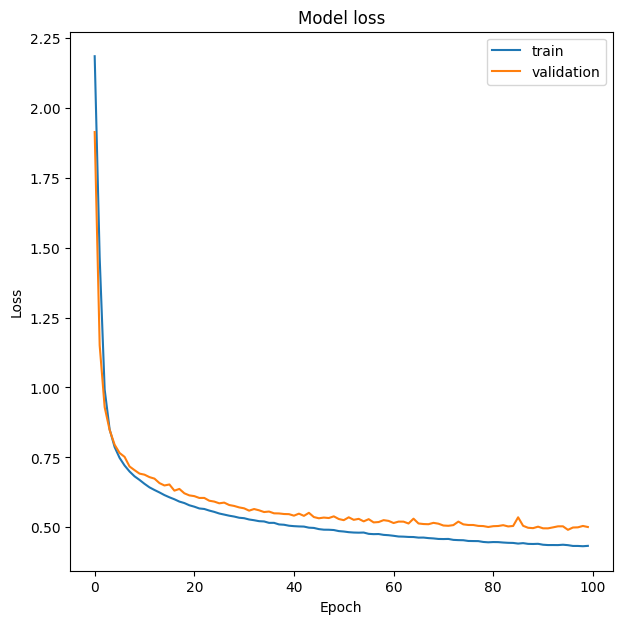

In [15]:
df_loss.plot(
    title='Model loss',
    figsize=(7, 7)
).set(xlabel='Epoch', ylabel='Loss')

[Text(0.5, 0, 'Epoch'), Text(0, 0.5, 'Accuracy')]

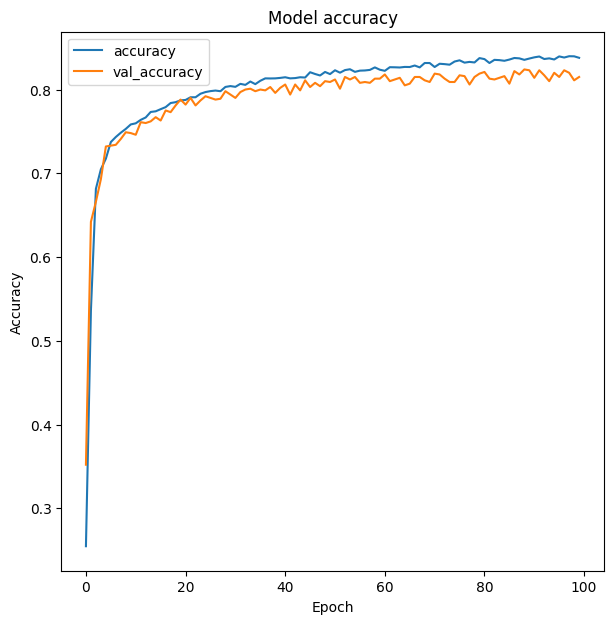

In [16]:
df_acc.plot(
    title='Model accuracy',
    figsize=(7, 7)
).set(xlabel='Epoch', ylabel='Accuracy')

### Test errors

Finally we evaluate the model on our test dataset.

In [17]:
clf.evaluate(ds_test=ds_test)

16/16 [==============================] - 0s 6ms/step - loss: 0.5472 - accuracy: 0.7930


2023-05-21 19:54:59.274176: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int64 and shape [1]
	 [[{{node Placeholder/_4}}]]
2023-05-21 19:54:59.274759: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int64 and shape [1]
	 [[{{node Placeholder/_4}}]]
